In [1]:
import numpy as np
import pandas as pd
import io
import cv2
import random
from IPython.display import clear_output, Image, display
import PIL.Image
from ipysheet import sheet,cell,row,column,cell_range,from_dataframe

In [2]:
import gerber # https://pcb-tools.readthedocs.io/en/latest/documentation/rs274x.html#functions
stencil = gerber.read('solderpaste_top8.gbr') # read gerber file from eagle or Kicad
bound_x = stencil.bounds[0][1] + stencil.bounds[0][0]
bound_y = stencil.bounds[1][1] + stencil.bounds[1][0]
print("from gerber mm",bound_x,bound_y," CV Ver:",cv2.__version__)
def showarray(a, fmt='png'):   # Helper Function to Draw cv2 images in jupyter
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
stencil.bounds # Middle Points of max outside Pads

from gerber mm 29.0298 19.9644  CV Ver: 4.5.1


((1.8622, 27.1676), (3.5696, 16.3948))

3715 2555


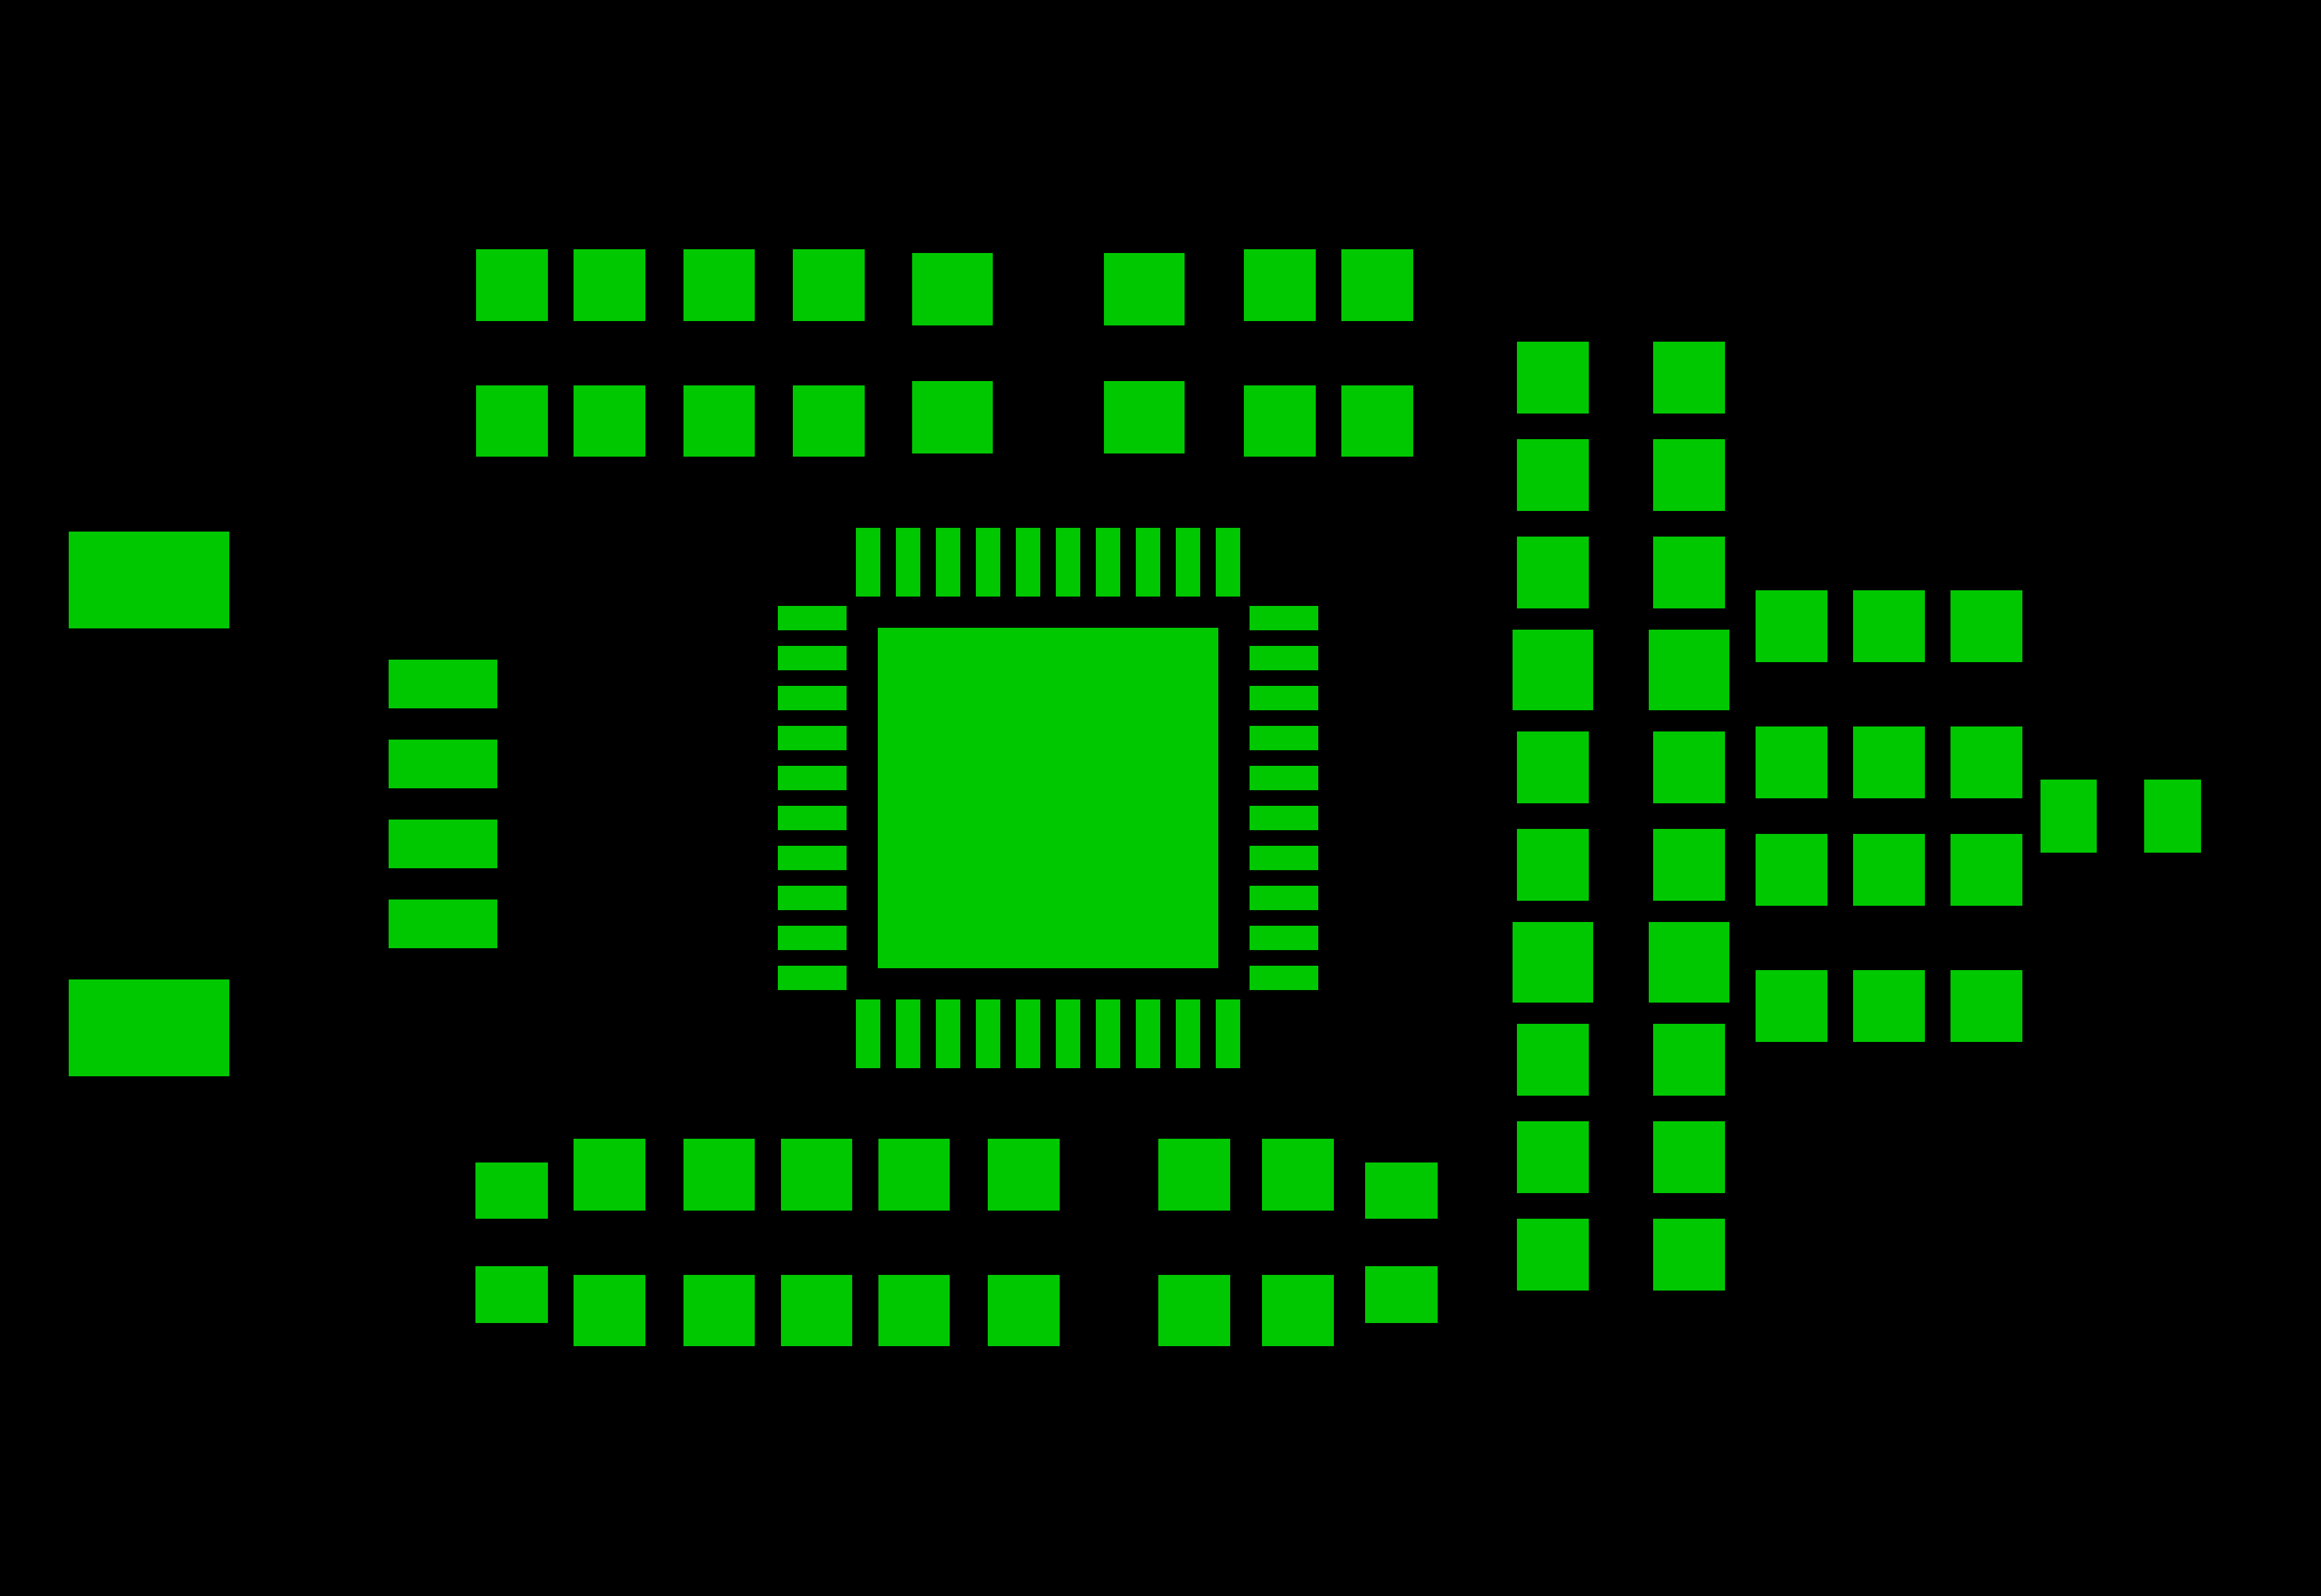

In [3]:
#bound_x=70
#bound_y=110
#xcf = 2
#ycf = 110

xcf = 0 # use this offset if gerber have neg cords
ycf = 0 # use this offset if gerber have neg cords

img_scale = 128.0

# create a new Image using 128px per mm
height = int(bound_y * img_scale)  #+ 256
width  = int(bound_x * img_scale)  #+ 256

print(width,height)
blank_image = np.zeros((height,width,3), np.uint8)
for i in stencil.primitives: # draw pads from gerber file
    if isinstance(i,gerber.primitives.Line ): # some elements are simple lines,need also thickness to correct fill 
        p1 = (int((i._start[0]+xcf) * img_scale) , int((i._start[1]+ycf) * img_scale))
        p2 = (int((i._end[0]+xcf)   * img_scale) , int((i._end[1]+ycf)   * img_scale) )
        #print(p1,p2)
        cv2.line(   img=blank_image, pt1=p1,pt2=p2, 
                    color=(255,0,0) , thickness = int(i.aperture._diameter*img_scale) , lineType = 8, shift = 0)
    elif isinstance(i,gerber.primitives.Rectangle ): # draw rectanges
        x1 = int(((i._position[0] - i._width * 0.5)+xcf)  * img_scale)
        y1 = int(((i._position[1] - i._height* 0.5)+ycf)  * img_scale)
        x2 = int(((i._position[0] + i._width * 0.5)+xcf)  * img_scale)
        y2 = int(((i._position[1] + i._height* 0.5)+ycf)  * img_scale)
        #print(x1,y1,x2,y2)
        cv2.rectangle(blank_image, (x1,y1), (x2,y2), color=(0,200,0), thickness = -1)
    elif isinstance(i,gerber.primitives.Obround ): # draw rectanges
        #print(i.__dict__)
        x1 = int(((i._position[0] - i._width * 0.5)+xcf)  * img_scale)
        y1 = int(((i._position[1] - i._height* 0.5)+ycf)  * img_scale)
        x2 = int(((i._position[0] + i._width * 0.5)+xcf)  * img_scale)
        y2 = int(((i._position[1] + i._height* 0.5)+ycf)  * img_scale)
        #print(x1,y1,x2,y2)
        cv2.rectangle(blank_image, (x1,y1), (x2,y2), color=(0,200,0), thickness = -1)
    else: # print unknown Objects rectanges
        #print(i)
        pass
flip_img = cv2.flip(blank_image, -1)
flip_img = cv2.flip(flip_img, 1)
showarray(flip_img)

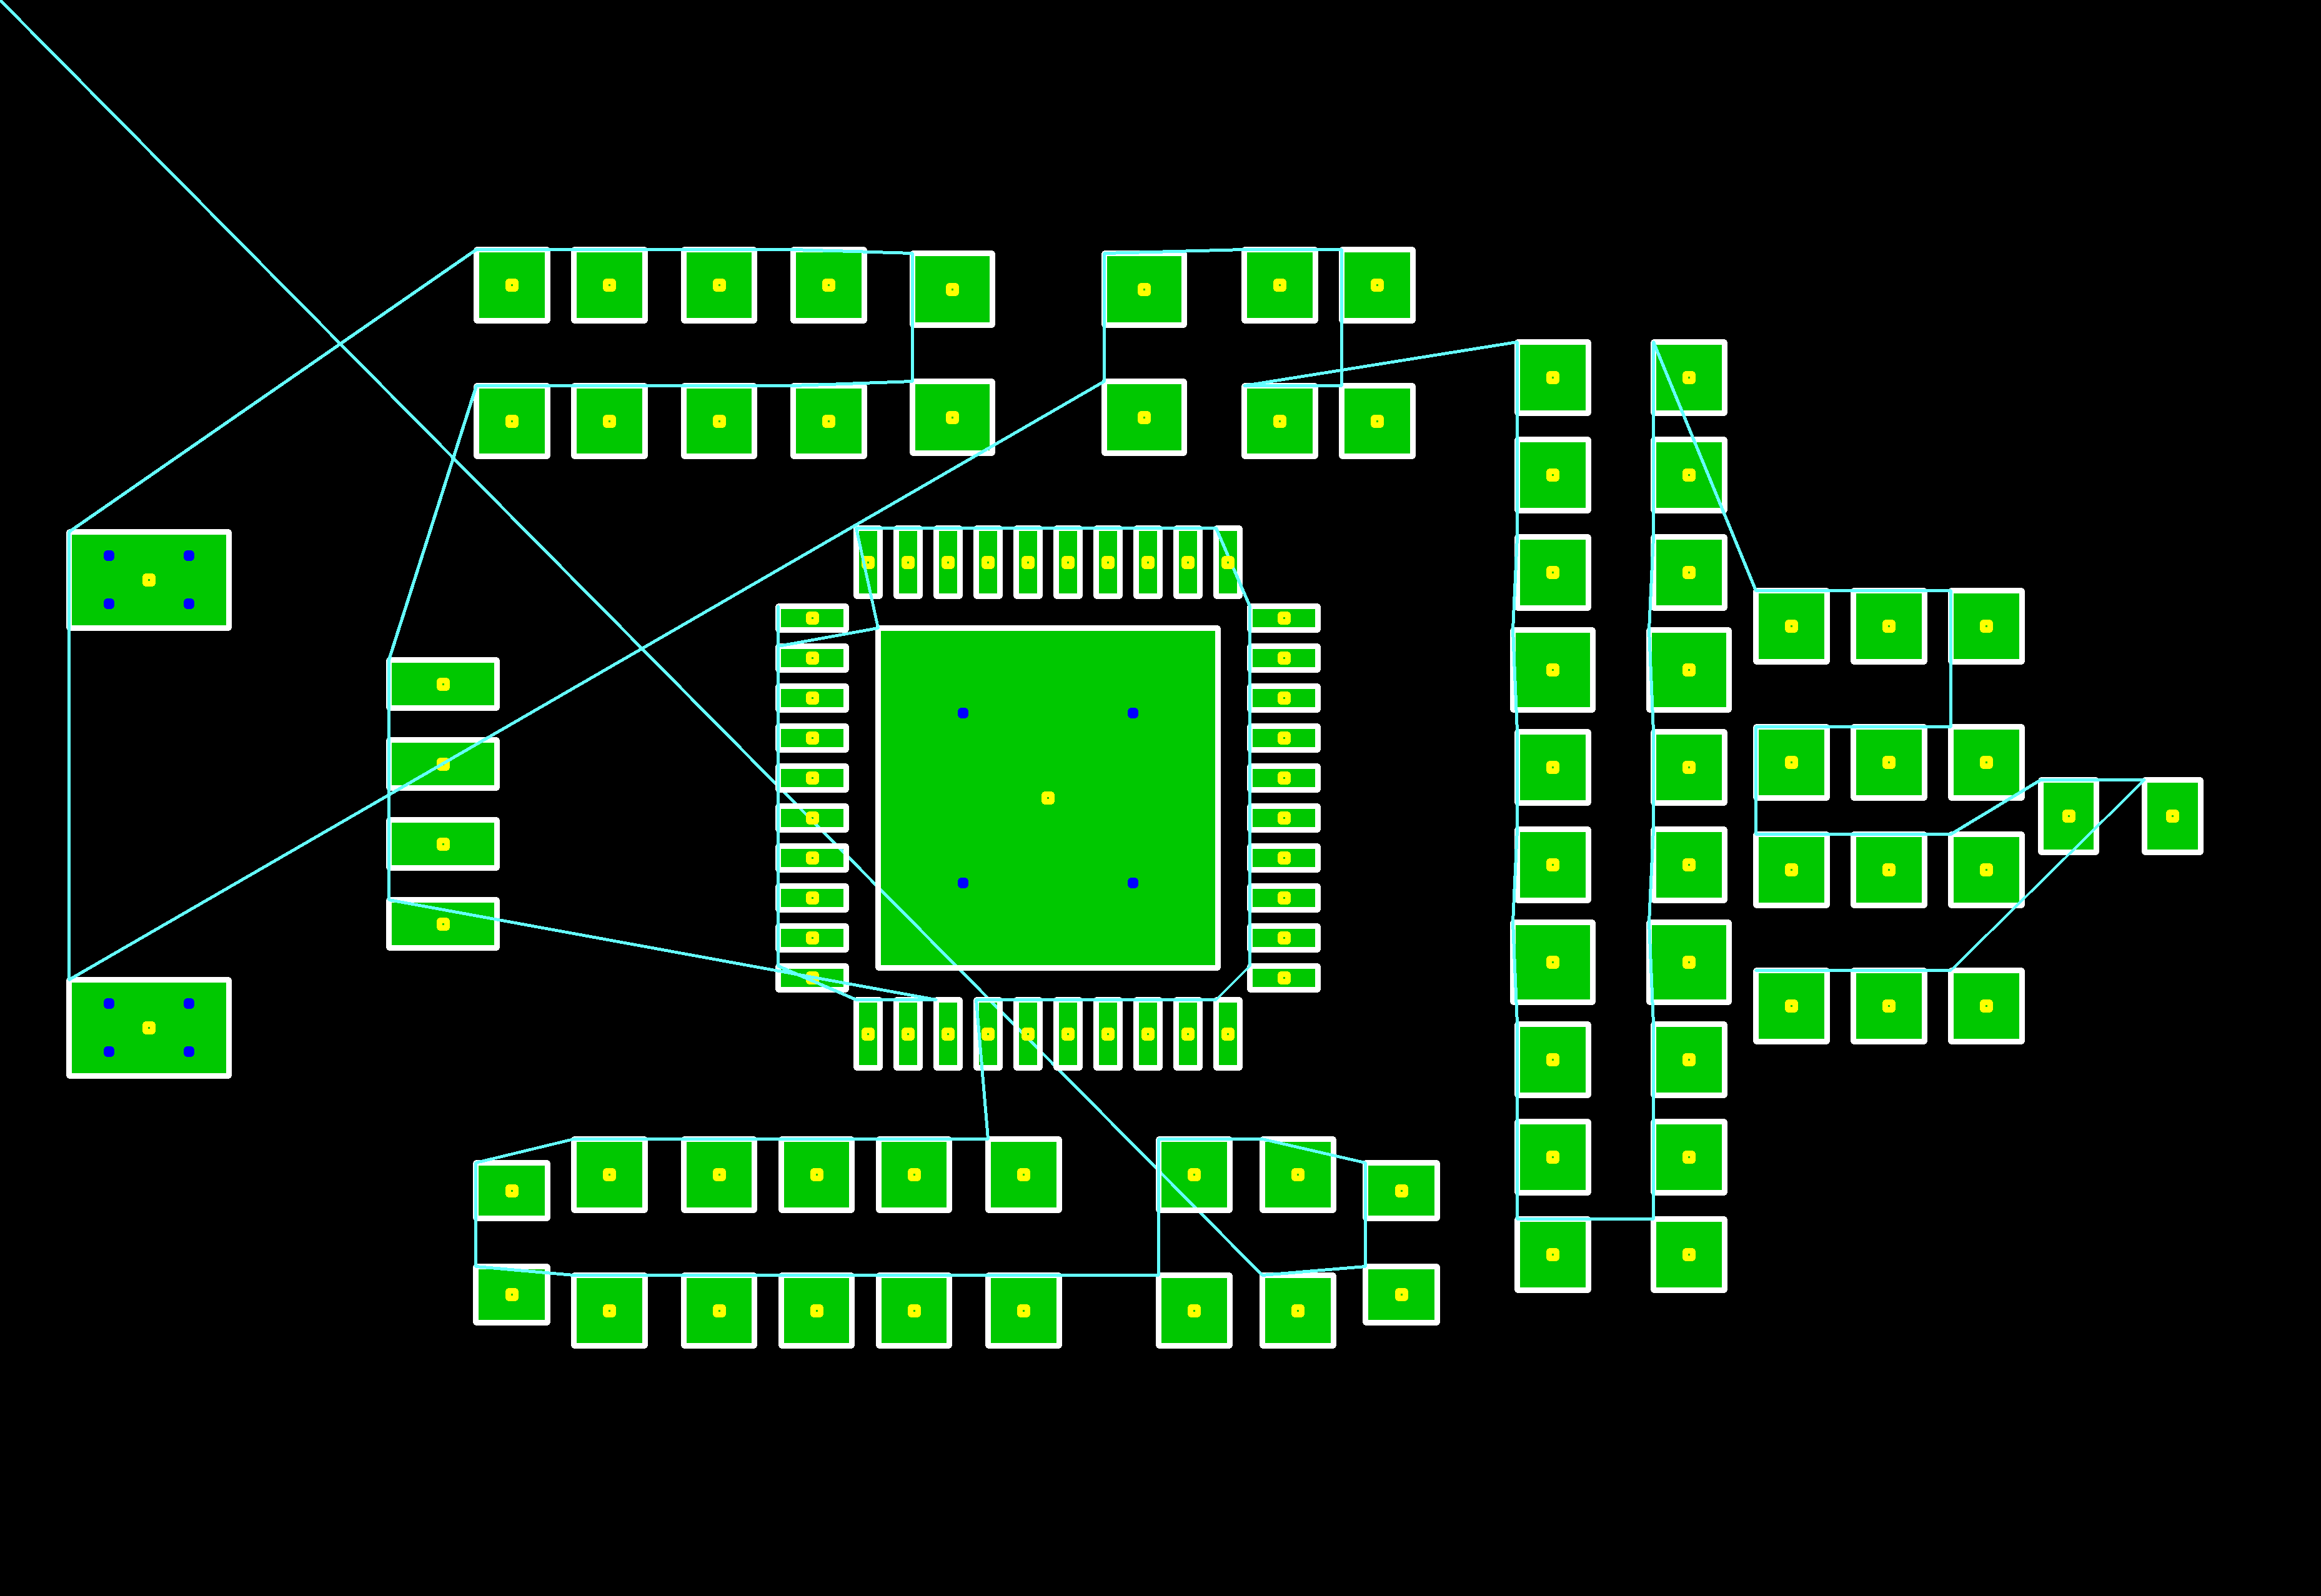

Pad Counter: 127


In [4]:
# found contours to find solder paste points
imgOrg   = flip_img.copy()  
imgGray  = cv2.cvtColor(flip_img,cv2.COLOR_BGR2GRAY)
contours, hierarchy  = cv2.findContours(imgGray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
mdata = [] # output data for maschine
x_old=0
y_old=0 # for route 



def distance_contour(c1, c2): # compute distance 2 points 
    x1, y1, w1, h1 = cv2.boundingRect(c1)
    x2, y2, w2, h2 = cv2.boundingRect(c2)
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5
def tsp_len(seq): # compute distance full path
    l=0
    fr=seq[0]
    for i, contour in enumerate(seq):
        l=l+distance_contour(fr,contour)
        fr=contour
    return l
'''
## START optimize route by simple TSP heuristic
def swap_random(seq): # random swap elements
    idx = range(len(seq))
    i1, i2 = random.sample(idx, 2)
    seq[i1], seq[i2] = seq[i2], seq[i1]
def optimize_path(path, iterations=30000):
    l=tsp_len(path)
    for i in range(0, iterations): # <--- tune high values -> cpu load
        ccopy = path.copy()
        for ii in range(1, random.randint(1,7)): swap_random(ccopy) # random swaps
        lnew=tsp_len(ccopy)
        if lnew < l :
            l = lnew
            path = ccopy # apply when shorter path found
        if (i % 10000) == 0:  print("mm drive len:", l)
    print("New mm drive len:", l)
    return path
## END optimize route by simple TSP heuristic
'''

def get_sort_list_by_start_point(pts, fr):
   pts.sort(key = lambda p: distance_contour(p,fr))
   return pts
def optimize_path2(path):
    dest=[]
    dest.append(path[0])
    path.remove(path[0])
    while len(path) > 0:
        sort_list = get_sort_list_by_start_point(path,dest[-1])
        dest.append(path[0])
        path.remove(path[0])
    return dest

#print("drive len:", tsp_len(contours) / img_scale)
contours = optimize_path2(contours)
#print("New mm drive len:", tsp_len(contours) / img_scale)

counter  = 0
for i, contour in enumerate(contours):
    #print(i);
    x, y, w, h = cv2.boundingRect(contour)
    if(x==0 & y==0): continue
    center1 = (x+w//2 -6, y+h//2 -6)
    center2 = (x+w//2 +6, y+h//2 +6)
    mdata.append({'cnt': counter, 'x': (x+w//2)/img_scale  , 'y': bound_y-(y+h//2)/img_scale , 'sub': False, 'ready': False})
    counter=counter+1
    cv2.drawContours(imgOrg, contour, -1, (255, 255, 255), 8) # draw outline bounds
    cv2.line(   img=imgOrg, pt1=(x,y),pt2=(x_old,y_old), 
                    color=(100,255,255) , thickness = 4 , lineType = 8, shift = 0) # show trace, so looks like we need optimize driver too
    cv2.rectangle(imgOrg, center1, center2, (255, 255, 0), 8) # draw bounds
    #if w > 160 or h > 160: # draw some extra dots on bigger pads, need 
    if cv2.contourArea(contour) > 18800: # or check by area size <---NEED to TUNE
        for xd in np.arange (x + w//4  , x + w , w//2):
            for yd in np.arange (y + h//4  , y + h , h//2):
                center1 = (xd - 4, yd - 4)
                center2 = (xd + 4, yd + 4)
                if cv2.pointPolygonTest(contour,(xd,yd),False)==1 :
                    cv2.rectangle(imgOrg, center1, center2, (0, 0, 255), 8) # draw bounds, TODO: add some patterns for bigger pads
                    mdata.append({'cnt': counter, 'x': xd/img_scale  , 'y': bound_y-yd/img_scale , 'sub': True, 'ready': False})
                    counter=counter+1
    x_old = x
    y_old = y
showarray(imgOrg)
print("Pad Counter:", counter)


In [5]:
# solderpaste_top8.gbr FD1 UntenLinks 1.0668, 1.4224
# solderpaste_top8.gbr FD1 ObenRechts 28.4988, 18.4404
#

        
        
fducials = { 'fd1': { 'x':1.0668 , 'y':1.4224} , 
             'fd2': {'x':28.4988, 'y':18.4404} } # for solderpaste_top8.gbr
%store fducials
%store mdata
df = pd.DataFrame(mdata)
df

Stored 'fducials' (dict)
Stored 'mdata' (list)


,cnt,x,y,sub,ready
0,0,16.226562,3.573775,False,False
1,1,17.523438,3.776900,False,False
2,2,17.523438,5.073775,False,False
3,3,16.226562,5.276900,False,False
4,4,14.929688,5.276900,False,False
...,...,...,...,...,...
122,122,25.867188,9.761275,False,False
123,123,27.164062,9.761275,False,False
124,124,24.835938,7.386275,False,False
125,125,23.617188,7.386275,False,False


In [6]:
sheet1 = from_dataframe(df[:20]) # bad performance when show all
display(sheet1)

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format='0[.]0', row_end=19, row_start=0, squeeze_row=F…